In [423]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [424]:
df = pd.read_csv('../dataset/dataset-vieclam24h.csv', sep=';')
column_mapping = {
    'Năm đăng': 'year',
    'Tháng đăng': 'month',
    'Ngày đăng': 'day',
    'Tỉnh/Thành phố': 'city',
    'Lĩnh vực tuyển dụng cấp 1 (CNTT/Du lịch/Điện, …)': 'job',
    'Số lượng tuyển dụng': 'number_of_job_posts'
}
df = df.rename(columns=column_mapping)
df = df.dropna(subset=['city'])
df = df.ffill()

df['time'] = pd.to_datetime(df[['year', 'month', 'day']])

aggregated_data = df.groupby(['job', 'city', 'time'])['number_of_job_posts'].sum().reset_index()

print(aggregated_data.head())

                job        city       time  number_of_job_posts
0  An ninh - Bảo vệ  Bình Dương 2024-12-10                    1
1  An ninh - Bảo vệ  Bình Dương 2024-12-12                    1
2  An ninh - Bảo vệ      Hà Nội 2024-12-10                    5
3  An ninh - Bảo vệ      Hà Nội 2024-12-12                   10
4  An ninh - Bảo vệ      Hà Nội 2024-12-24                    2


In [425]:
city_counts = aggregated_data['city'].value_counts()
job_counts = aggregated_data['job'].value_counts()

In [426]:
print(city_counts)

city
TP.HCM               327
Hà Nội               204
Bình Dương           113
Đà Nẵng               59
Đồng Nai              52
Long An               37
Vĩnh Long             28
Đắk Lắk               25
Bà Rịa - Vũng Tàu     23
Hải Phòng             22
Bắc Ninh              21
Hưng Yên              20
Tây Ninh              18
Bình Định             17
Nghệ An               15
Name: count, dtype: int64


In [422]:
print(job_counts)

job
Bán hàng - Kinh doanh                           126
Xây dựng                                         83
Kế toán                                          78
Hành chính - Thư ký                              48
Bán sỉ - Bán lẻ - Quản lý cửa hàng               45
Marketing                                        44
Khoa học - Kỹ thuật                              41
Điện - Điện tử - Điện lạnh                       36
Vận hành - Bảo trì - Bảo dưỡng                   34
Khách sạn - Nhà hàng - Du lịch                   34
Sản xuất - Lắp ráp - Chế biến                    30
Cơ khí - Ô tô - Tự động hóa                      30
Thu mua - Kho Vận - Chuỗi cung ứng               28
Lao động phổ thông                               27
Chăm sóc khách hàng                              24
Vận Tải - Lái xe - Giao nhận                     23
Giáo dục - Đào tạo                               22
Thiết kế - Sáng tạo nghệ thuật                   17
Kiến trúc - Thiết kế nội ngoại thất              15
Xuất Nhậ

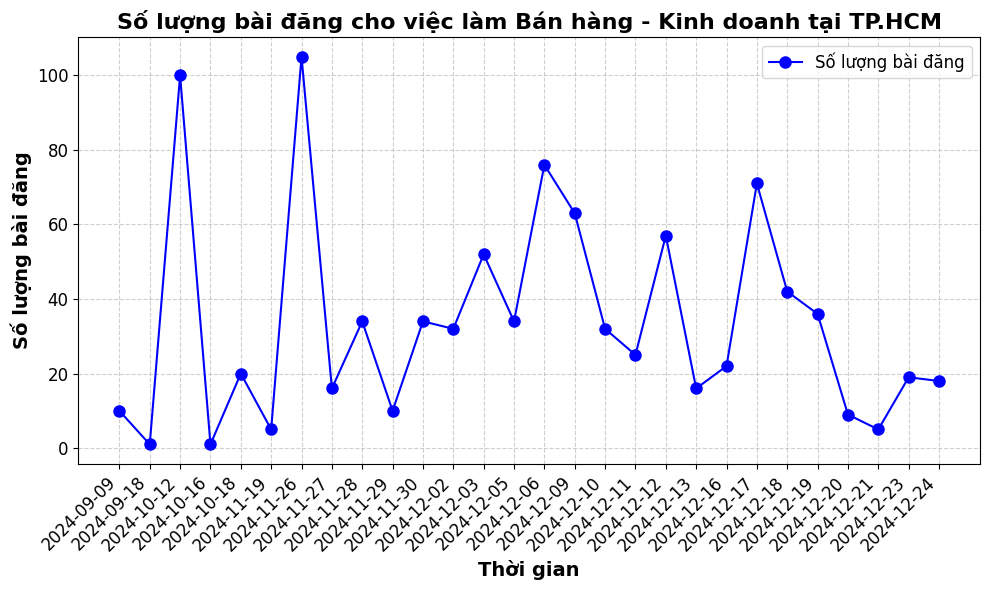

In [380]:
def plot_job_trend(job, city):
    job_data = aggregated_data[(aggregated_data['job'] == job) & (aggregated_data['city'] == city)]
    
    plt.figure(figsize=(10, 6))
    plt.plot(job_data['time'].astype(str), job_data['number_of_job_posts'], marker='o', linestyle='-', color='b', markersize=8, label='Số lượng bài đăng')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlabel('Thời gian', fontsize=14, fontweight='bold')
    plt.ylabel('Số lượng bài đăng', fontsize=14, fontweight='bold')
    plt.title(f'Số lượng bài đăng cho việc làm {job} tại {city}', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

plot_job_trend('Bán hàng - Kinh doanh', 'TP.HCM')

In [381]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
aggregated_data['scaled_posts'] = scaler.fit_transform(aggregated_data['number_of_job_posts'].values.reshape(-1, 1))

# Mã hóa cột 'job' và 'city' với LabelEncoder
job_encoder = LabelEncoder()
city_encoder = LabelEncoder()
aggregated_data['job_encoded'] = job_encoder.fit_transform(aggregated_data['job'])
aggregated_data['city_encoded'] = city_encoder.fit_transform(aggregated_data['city'])

In [382]:
print(aggregated_data.head())


                job        city       time  number_of_job_posts  scaled_posts  \
0  An ninh - Bảo vệ  Bình Dương 2024-12-10                    1      0.000000   
1  An ninh - Bảo vệ  Bình Dương 2024-12-12                    1      0.000000   
2  An ninh - Bảo vệ  Bình Phước 2024-12-03                    2      0.002004   
3  An ninh - Bảo vệ      Hà Nội 2024-12-10                    5      0.008016   
4  An ninh - Bảo vệ      Hà Nội 2024-12-12                   10      0.018036   

   job_encoded  city_encoded  
0            0             2  
1            0             2  
2            0             3  
3            0            13  
4            0            13  


In [403]:
def create_time_series(df, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(df) - time_steps):
        dataX.append(df[i : (i + time_steps), :])
        dataY.append(df[i + time_steps, -1])
    return np.array(dataX), np.array(dataY)

features = ['job_encoded', 'city_encoded', 'scaled_posts']
data_values = aggregated_data[features].values
time_steps = 5

X, y = create_time_series(data_values, time_steps)

In [404]:
# Chia dữ liệu thành tập train và test
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape dữ liệu để phù hợp với mô hình LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(features))
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], len(features))

In [405]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(784, 5, 3) (784,)
(197, 5, 3) (197,)


In [406]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='tanh'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
model.summary()

c:\Data\VScode-Workspace\CapstoneProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_100 (LSTM)                 │ (None, 5, 50)          │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 5, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_101 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 16)             │           816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,833 (124.35 KB)

 Trainable params: 31,833 (124.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0759 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0141 - val_loss: 3.1068e-04 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - val_loss: 2.4322e-04 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 - val_loss: 2.9099e-04 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 - val_loss: 2.4231e-04 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - val_loss: 2.7327e-04 - learning_rate: 0.0010
Epoch 7/100
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - val_loss: 4.8965e-04 - learning_rate: 0.0010
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - val_loss: 2.98

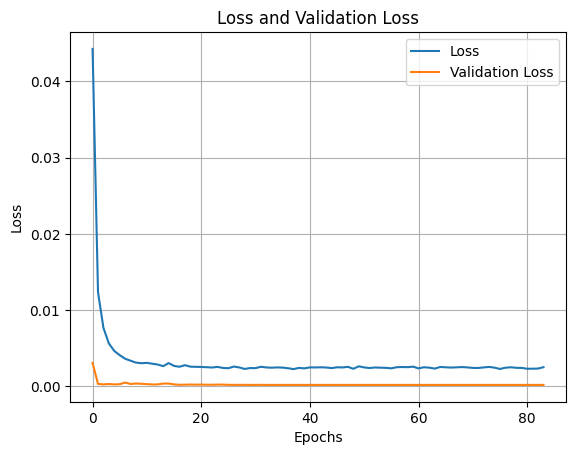

In [407]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
)

plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse_train = np.sqrt(mean_squared_error(y_train_inv, train_predict))
rmse_test = np.sqrt(mean_squared_error(y_test_inv, test_predict))

print(f"RMSE trên tập huấn luyện: {rmse_train}")
print(f"RMSE trên tập kiểm tra: {rmse_test}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
RMSE trên tập huấn luyện: 22.40811476933782
RMSE trên tập kiểm tra: 6.618338525317414


Không có dữ liệu cho công việc Vận Tải - Lái xe - Giao nhận tại Bắc Ninh


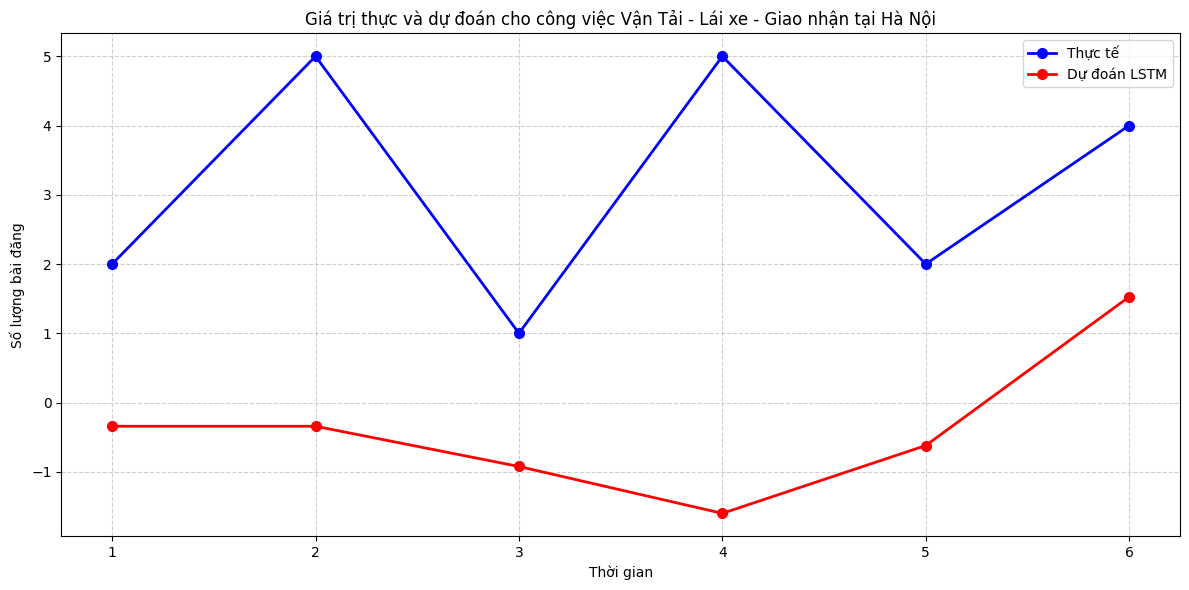

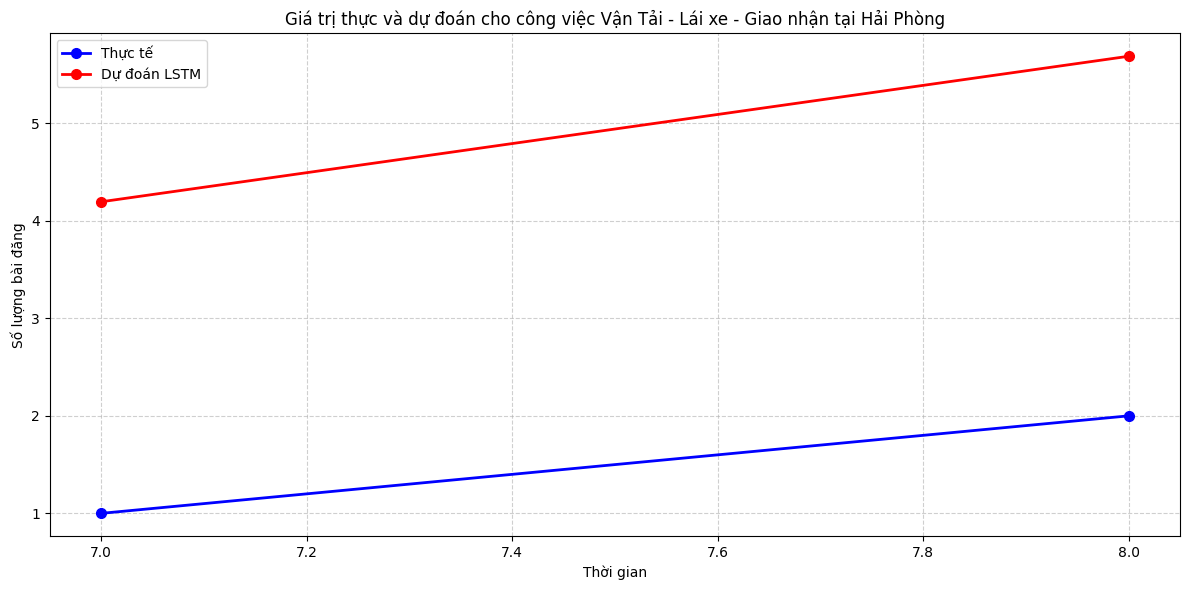

Không có dữ liệu cho công việc Vận Tải - Lái xe - Giao nhận tại Phú Yên
Không có dữ liệu cho công việc Vận Tải - Lái xe - Giao nhận tại Quảng Ngãi


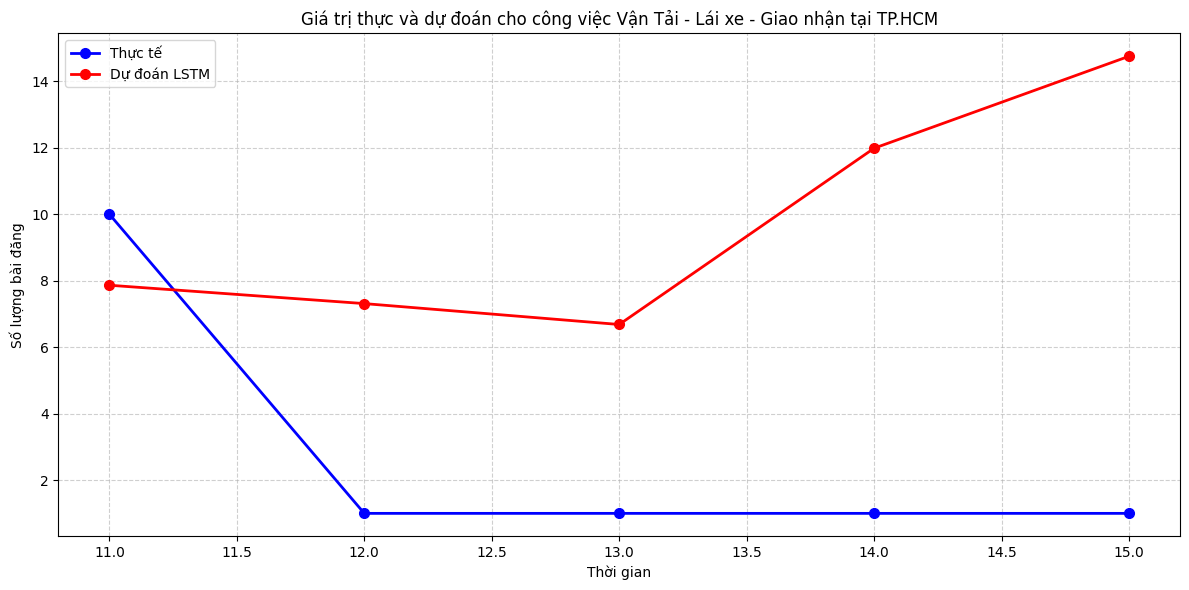

Không có dữ liệu cho công việc Vận Tải - Lái xe - Giao nhận tại Đà Nẵng
Không có dữ liệu cho công việc Vận Tải - Lái xe - Giao nhận tại Đồng Nai
Không có dữ liệu cho công việc Vận Tải - Lái xe - Giao nhận tại Bà Rịa - Vũng Tàu
Không có dữ liệu cho công việc Vận Tải - Lái xe - Giao nhận tại Bình Dương
Không có dữ liệu cho công việc Vận Tải - Lái xe - Giao nhận tại Bình Định
Không có dữ liệu cho công việc Vận Tải - Lái xe - Giao nhận tại Hưng Yên
Không có dữ liệu cho công việc Vận Tải - Lái xe - Giao nhận tại Nghệ An
Không có dữ liệu cho công việc Vận Tải - Lái xe - Giao nhận tại Tây Ninh
Không có dữ liệu cho công việc Vận Tải - Lái xe - Giao nhận tại Lâm Đồng
Không có dữ liệu cho công việc Vận Tải - Lái xe - Giao nhận tại Tiền Giang
Không có dữ liệu cho công việc Vận Tải - Lái xe - Giao nhận tại Bắc Giang
Không có dữ liệu cho công việc Vận Tải - Lái xe - Giao nhận tại Bến Tre
Không có dữ liệu cho công việc Vận Tải - Lái xe - Giao nhận tại Hải Dương
Không có dữ liệu cho công việc Vận Tải

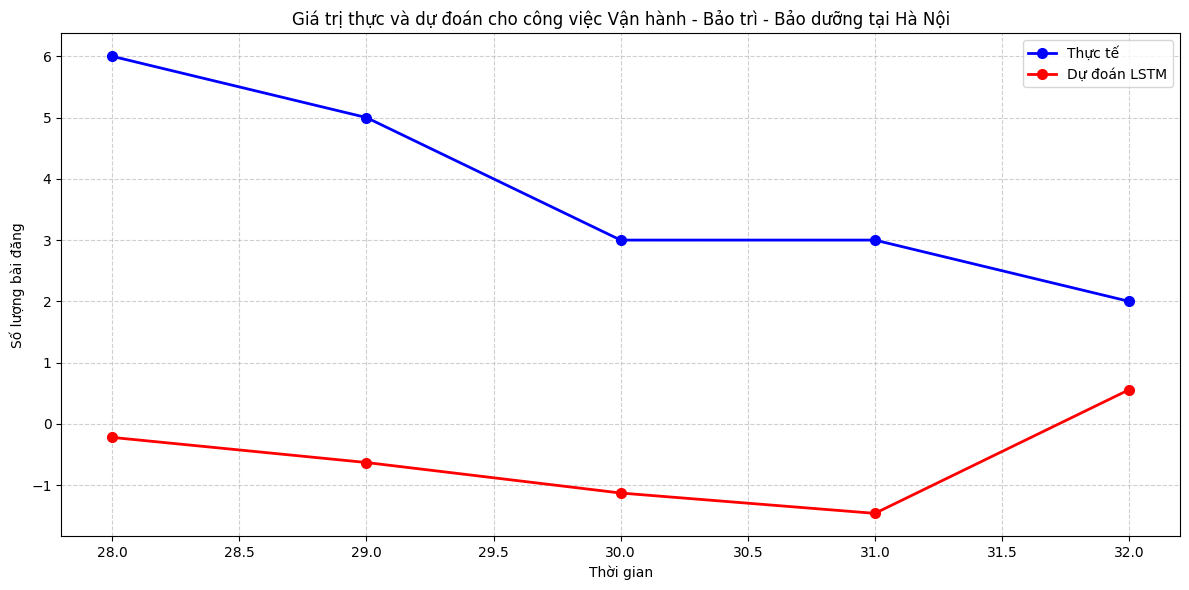

Không có dữ liệu cho công việc Vận hành - Bảo trì - Bảo dưỡng tại Hải Phòng
Không có dữ liệu cho công việc Vận hành - Bảo trì - Bảo dưỡng tại Phú Yên
Không có dữ liệu cho công việc Vận hành - Bảo trì - Bảo dưỡng tại Quảng Ngãi


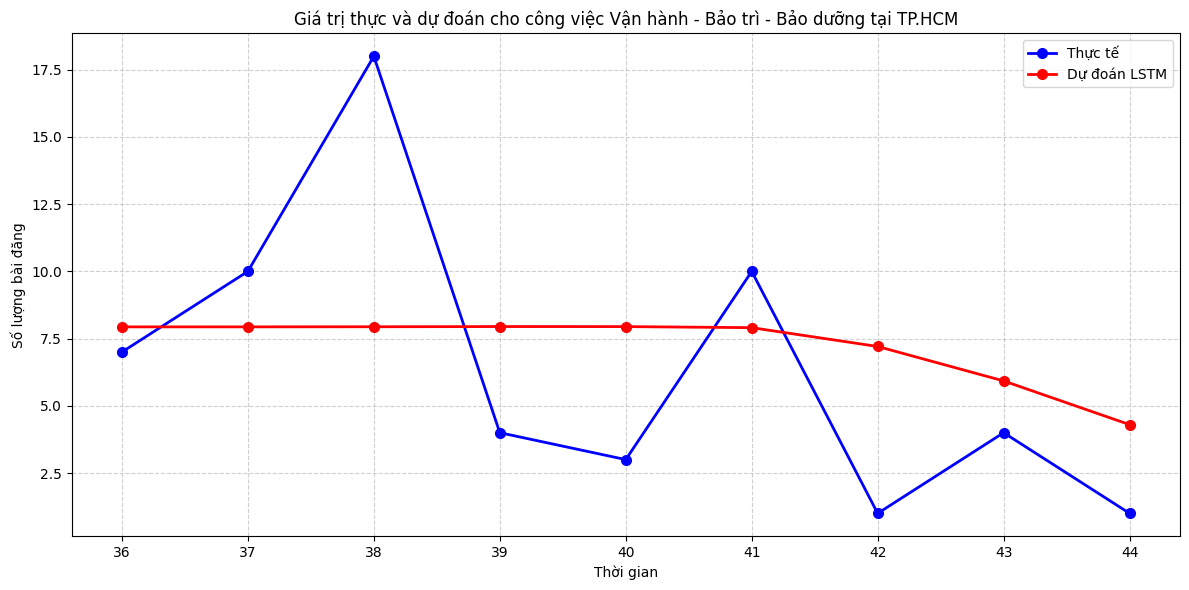

Không có dữ liệu cho công việc Vận hành - Bảo trì - Bảo dưỡng tại Đà Nẵng


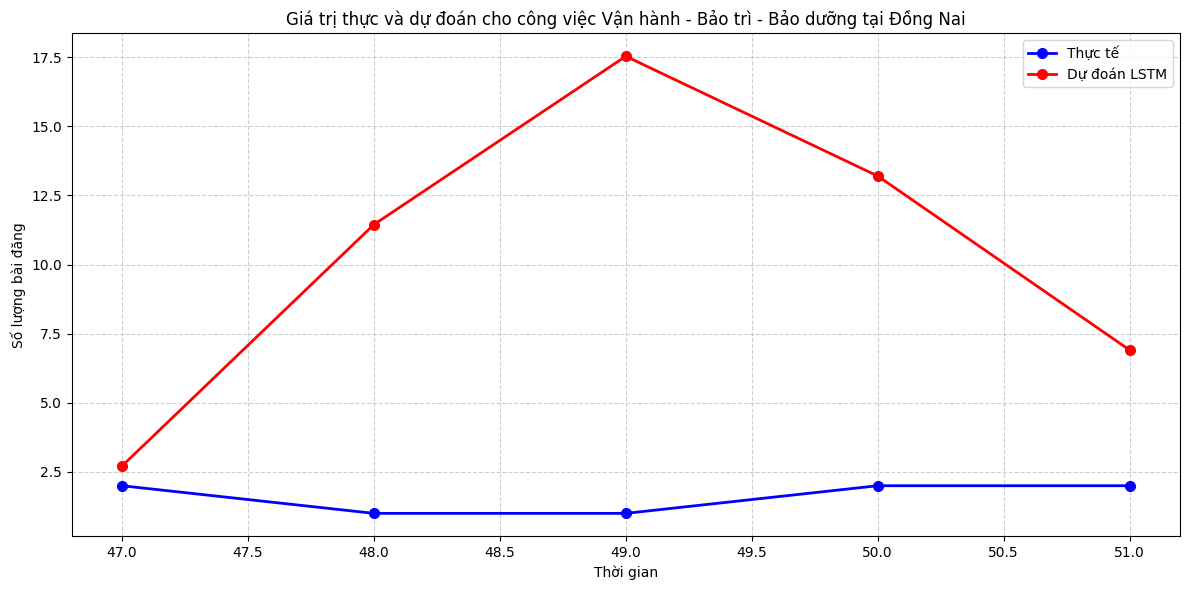

Không có dữ liệu cho công việc Vận hành - Bảo trì - Bảo dưỡng tại Bà Rịa - Vũng Tàu


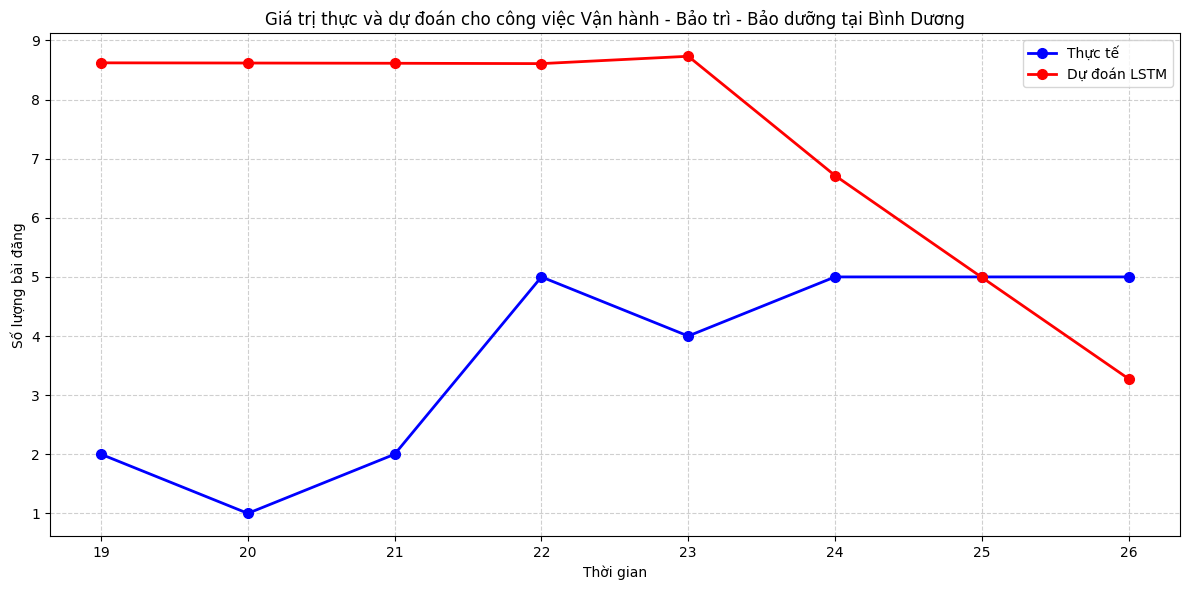

Không có dữ liệu cho công việc Vận hành - Bảo trì - Bảo dưỡng tại Bình Định


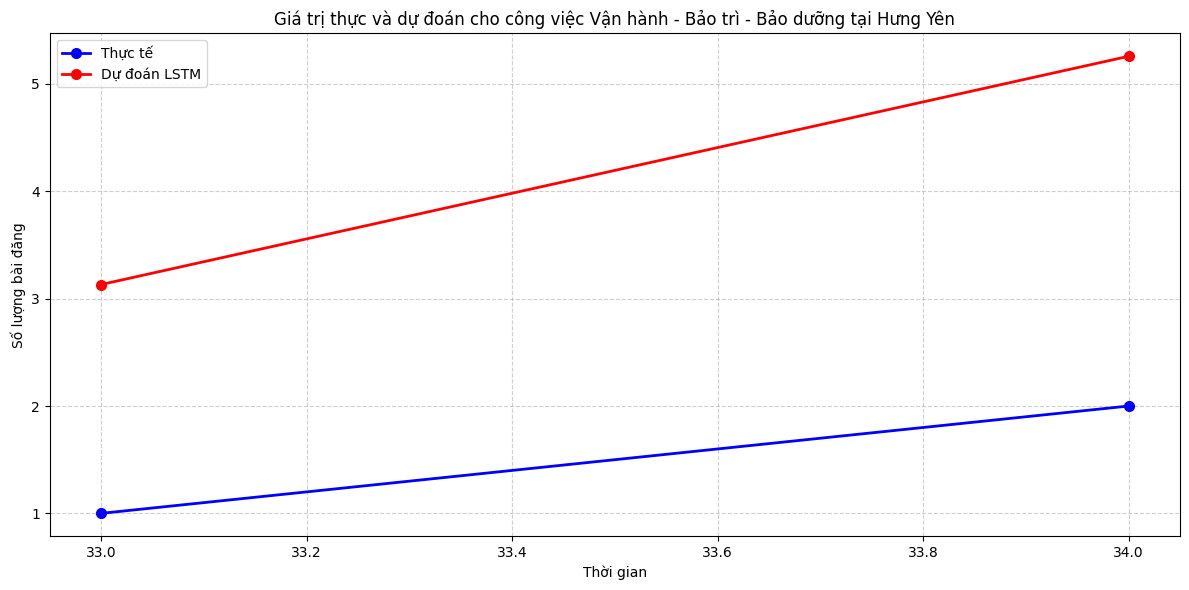

Không có dữ liệu cho công việc Vận hành - Bảo trì - Bảo dưỡng tại Nghệ An
Không có dữ liệu cho công việc Vận hành - Bảo trì - Bảo dưỡng tại Tây Ninh
Không có dữ liệu cho công việc Vận hành - Bảo trì - Bảo dưỡng tại Lâm Đồng
Không có dữ liệu cho công việc Vận hành - Bảo trì - Bảo dưỡng tại Tiền Giang
Không có dữ liệu cho công việc Vận hành - Bảo trì - Bảo dưỡng tại Bắc Giang
Không có dữ liệu cho công việc Vận hành - Bảo trì - Bảo dưỡng tại Bến Tre
Không có dữ liệu cho công việc Vận hành - Bảo trì - Bảo dưỡng tại Hải Dương
Không có dữ liệu cho công việc Vận hành - Bảo trì - Bảo dưỡng tại Long An
Không có dữ liệu cho công việc Vận hành - Bảo trì - Bảo dưỡng tại Quảng Ninh
Không có dữ liệu cho công việc Vận hành - Bảo trì - Bảo dưỡng tại Thanh Hóa
Không có dữ liệu cho công việc Vận hành - Bảo trì - Bảo dưỡng tại Vĩnh Long
Không có dữ liệu cho công việc Vận hành - Bảo trì - Bảo dưỡng tại Đắk Lắk
Không có dữ liệu cho công việc Xuất Nhập Khẩu tại Bắc Ninh


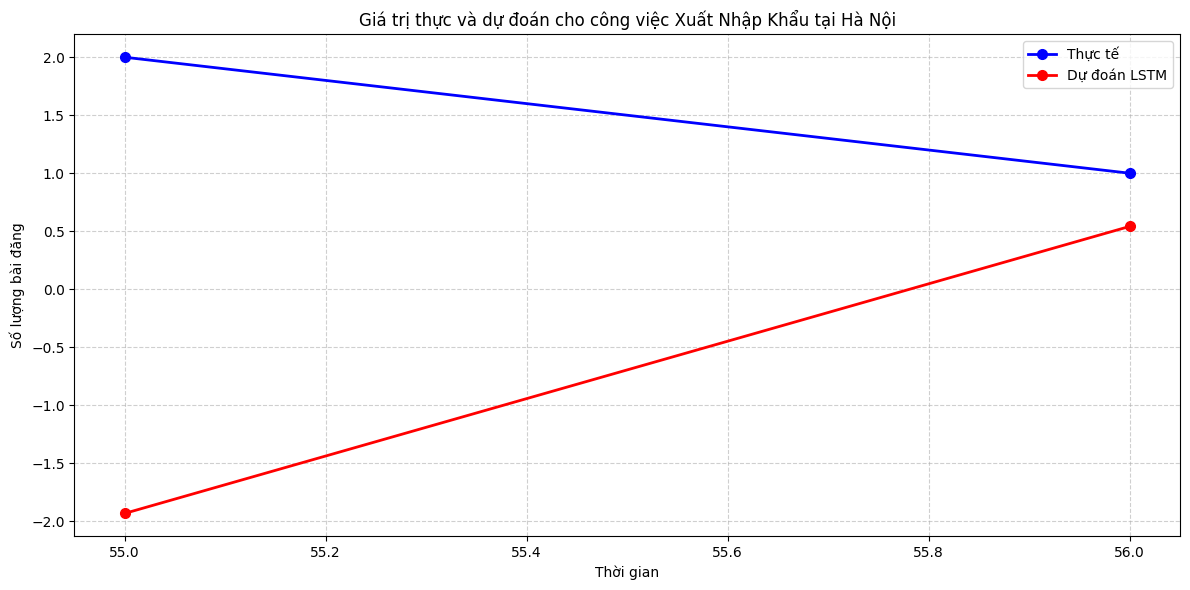

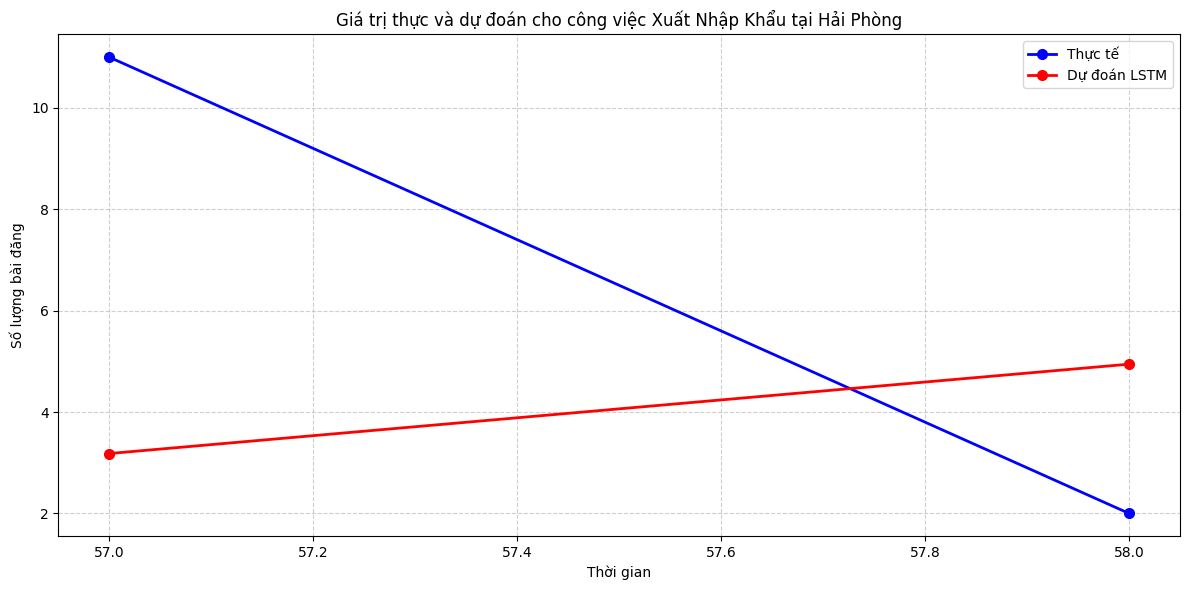

Không có dữ liệu cho công việc Xuất Nhập Khẩu tại Phú Yên
Không có dữ liệu cho công việc Xuất Nhập Khẩu tại Quảng Ngãi


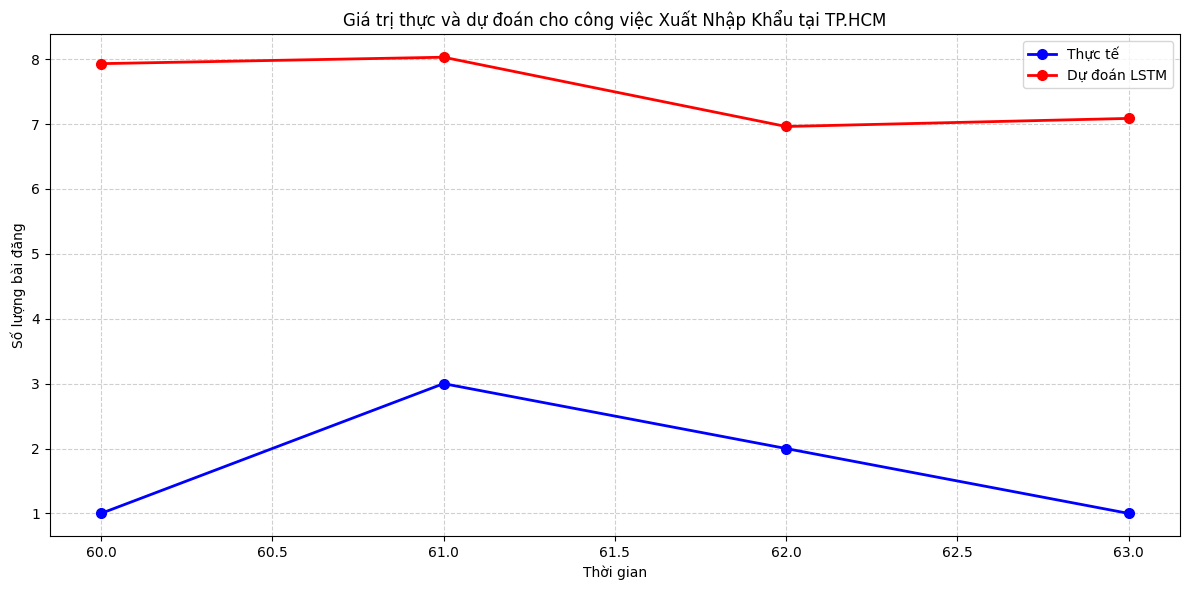

Không có dữ liệu cho công việc Xuất Nhập Khẩu tại Đà Nẵng
Không có dữ liệu cho công việc Xuất Nhập Khẩu tại Đồng Nai
Không có dữ liệu cho công việc Xuất Nhập Khẩu tại Bà Rịa - Vũng Tàu


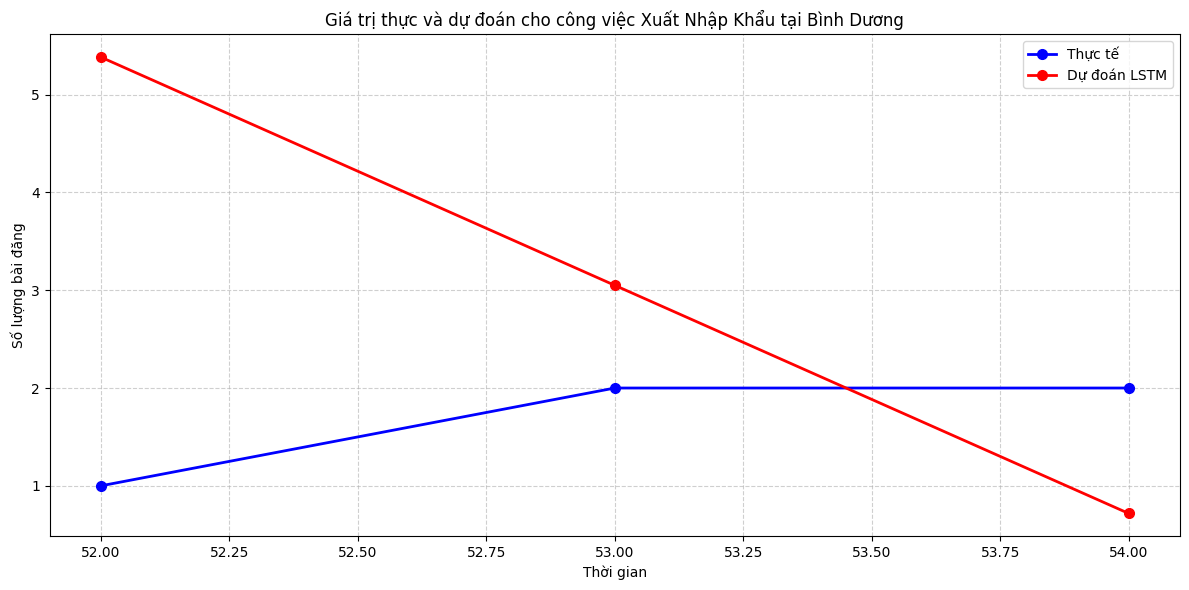

Không có dữ liệu cho công việc Xuất Nhập Khẩu tại Bình Định
Không có dữ liệu cho công việc Xuất Nhập Khẩu tại Hưng Yên
Không có dữ liệu cho công việc Xuất Nhập Khẩu tại Nghệ An
Không có dữ liệu cho công việc Xuất Nhập Khẩu tại Tây Ninh
Không có dữ liệu cho công việc Xuất Nhập Khẩu tại Lâm Đồng
Không có dữ liệu cho công việc Xuất Nhập Khẩu tại Tiền Giang
Không có dữ liệu cho công việc Xuất Nhập Khẩu tại Bắc Giang
Không có dữ liệu cho công việc Xuất Nhập Khẩu tại Bến Tre
Không có dữ liệu cho công việc Xuất Nhập Khẩu tại Hải Dương
Không có dữ liệu cho công việc Xuất Nhập Khẩu tại Long An
Không có dữ liệu cho công việc Xuất Nhập Khẩu tại Quảng Ninh
Không có dữ liệu cho công việc Xuất Nhập Khẩu tại Thanh Hóa
Không có dữ liệu cho công việc Xuất Nhập Khẩu tại Vĩnh Long
Không có dữ liệu cho công việc Xuất Nhập Khẩu tại Đắk Lắk
Không có dữ liệu cho công việc Xuất bản - In ấn tại Bắc Ninh
Không có dữ liệu cho công việc Xuất bản - In ấn tại Hà Nội
Không có dữ liệu cho công việc Xuất bản - In ấn t

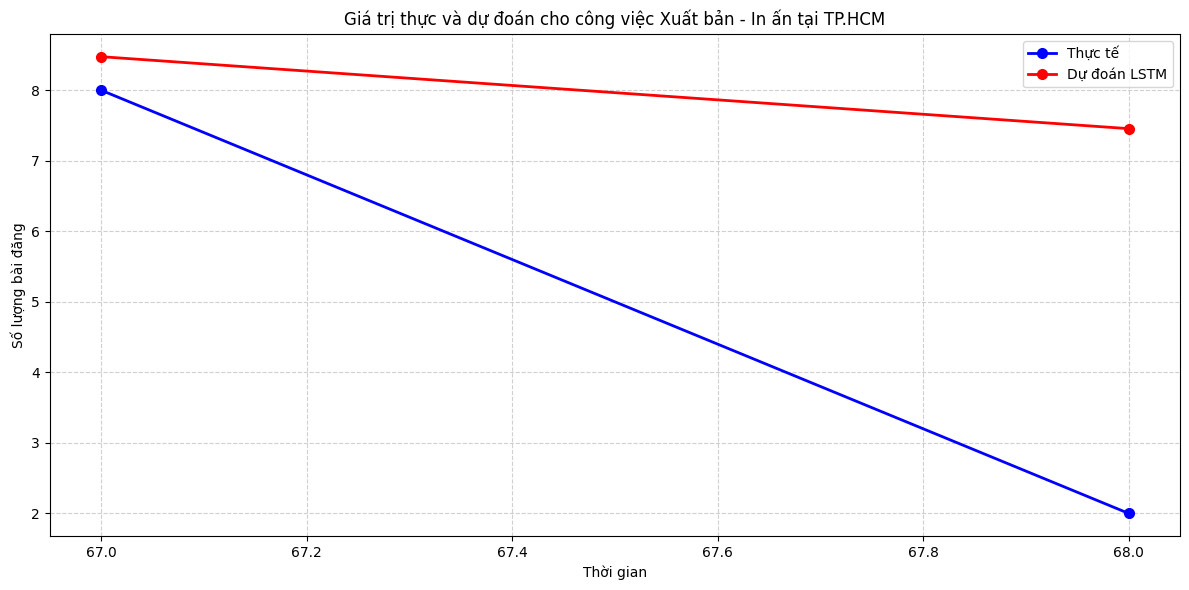

Không có dữ liệu cho công việc Xuất bản - In ấn tại Đà Nẵng
Không có dữ liệu cho công việc Xuất bản - In ấn tại Đồng Nai
Không có dữ liệu cho công việc Xuất bản - In ấn tại Bà Rịa - Vũng Tàu
Không có dữ liệu cho công việc Xuất bản - In ấn tại Bình Dương
Không có dữ liệu cho công việc Xuất bản - In ấn tại Bình Định
Không có dữ liệu cho công việc Xuất bản - In ấn tại Hưng Yên
Không có dữ liệu cho công việc Xuất bản - In ấn tại Nghệ An
Không có dữ liệu cho công việc Xuất bản - In ấn tại Tây Ninh
Không có dữ liệu cho công việc Xuất bản - In ấn tại Lâm Đồng
Không có dữ liệu cho công việc Xuất bản - In ấn tại Tiền Giang
Không có dữ liệu cho công việc Xuất bản - In ấn tại Bắc Giang
Không có dữ liệu cho công việc Xuất bản - In ấn tại Bến Tre
Không có dữ liệu cho công việc Xuất bản - In ấn tại Hải Dương
Không có dữ liệu cho công việc Xuất bản - In ấn tại Long An
Không có dữ liệu cho công việc Xuất bản - In ấn tại Quảng Ninh
Không có dữ liệu cho công việc Xuất bản - In ấn tại Thanh Hóa
Không có 

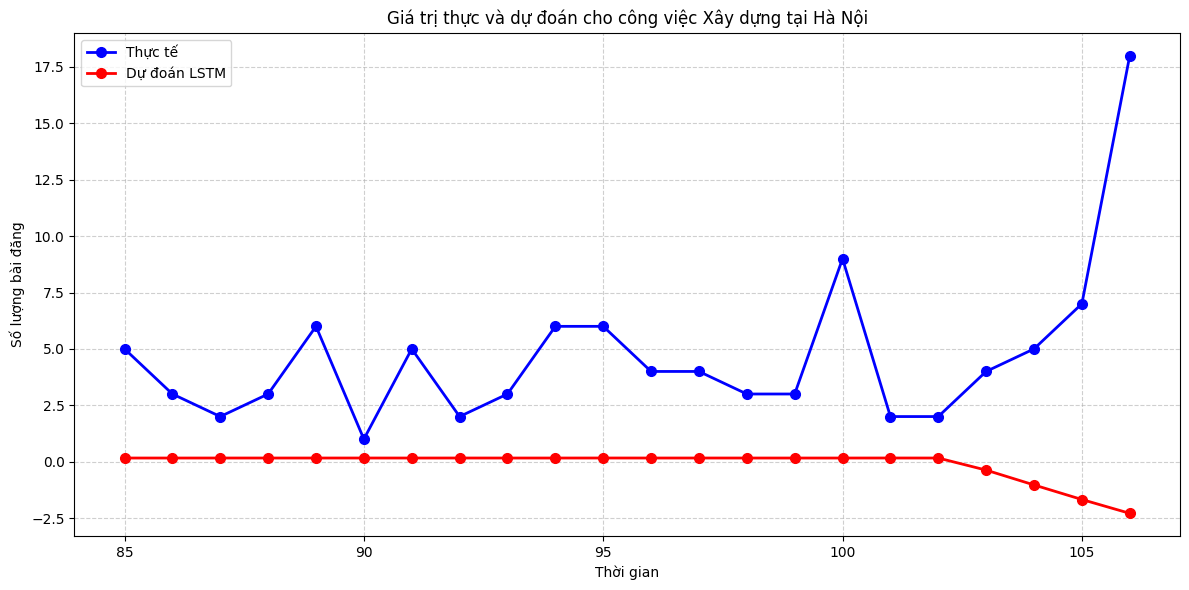

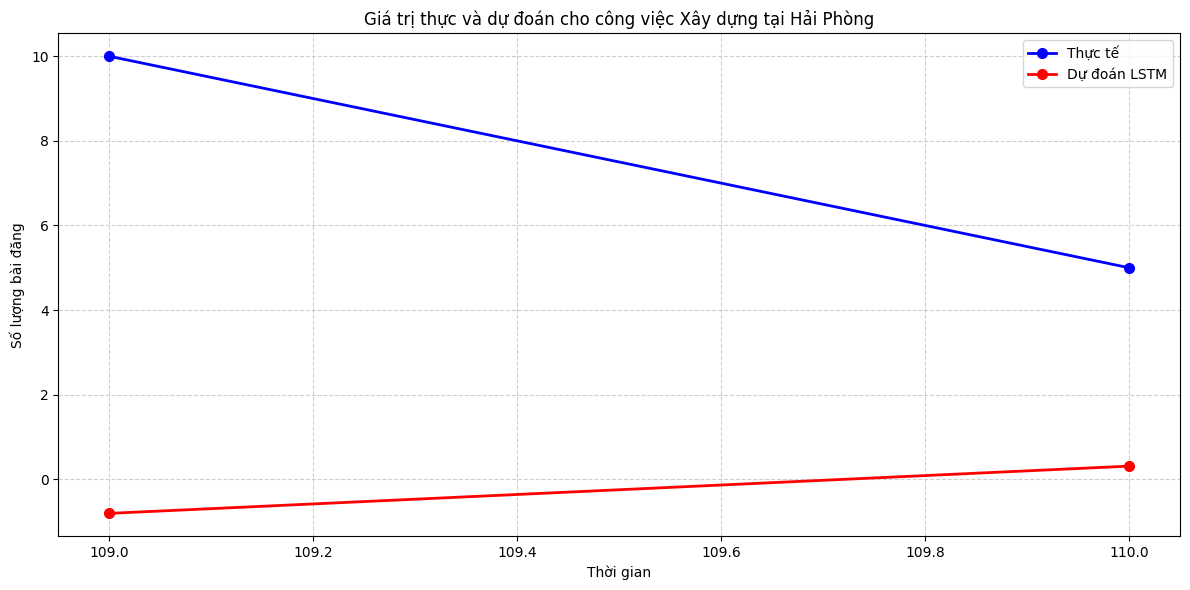

Không có dữ liệu cho công việc Xây dựng tại Phú Yên
Không có dữ liệu cho công việc Xây dựng tại Quảng Ngãi


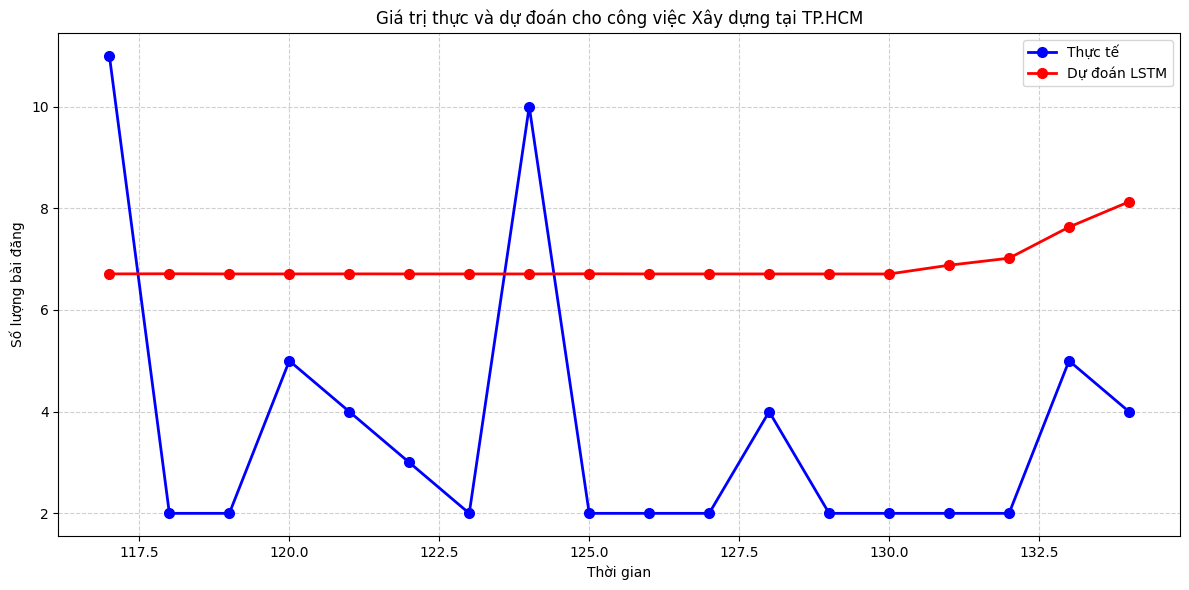

Không có dữ liệu cho công việc Xây dựng tại Đà Nẵng


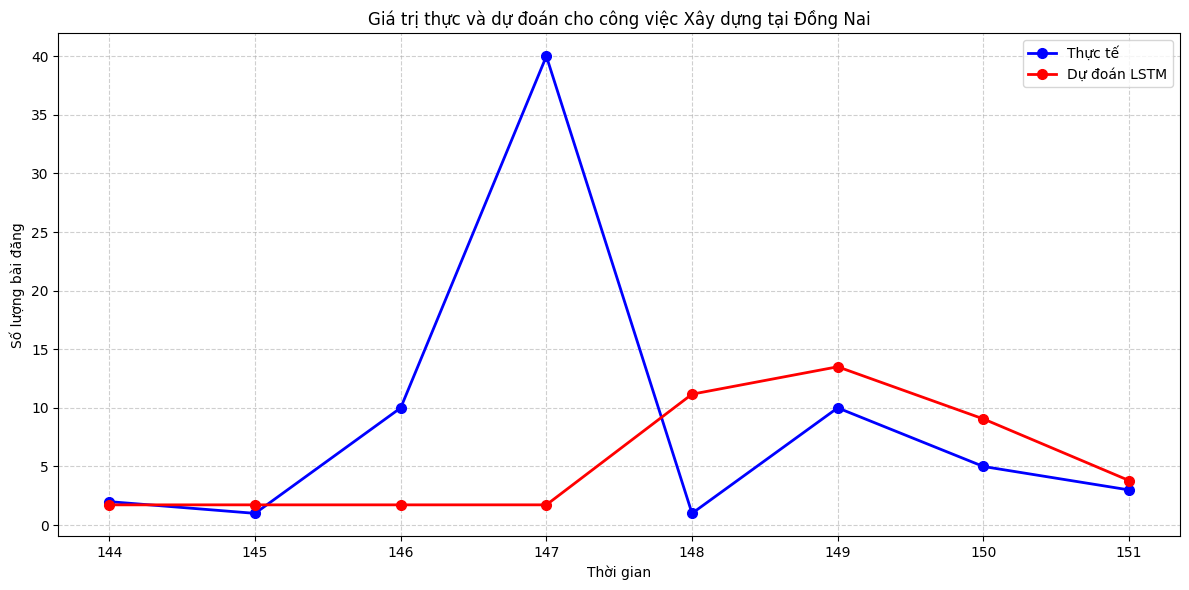

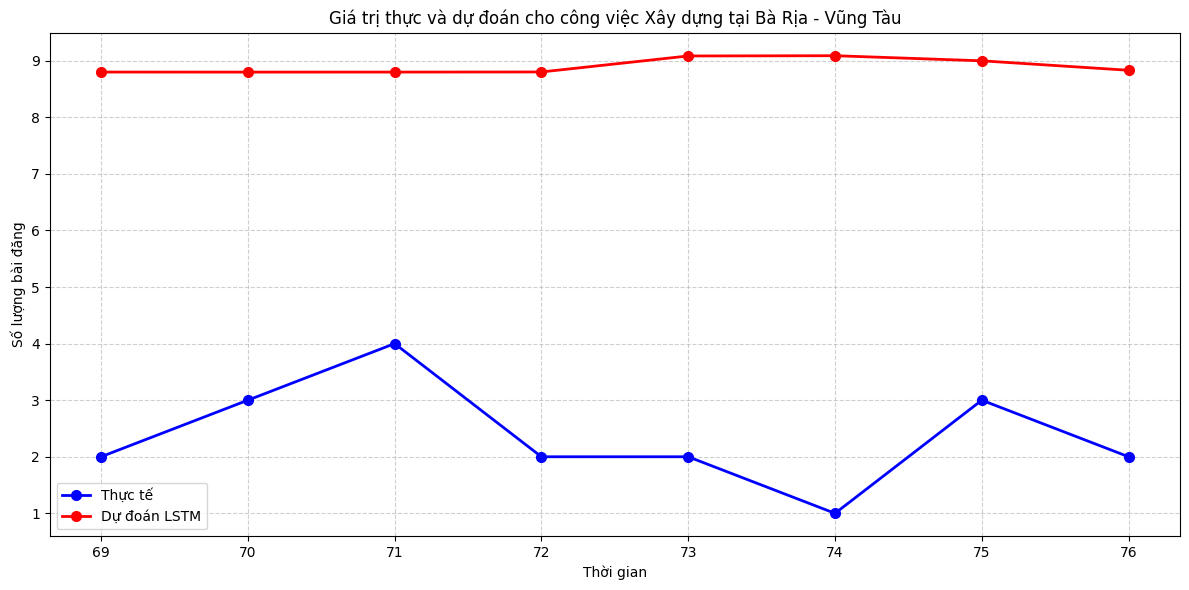

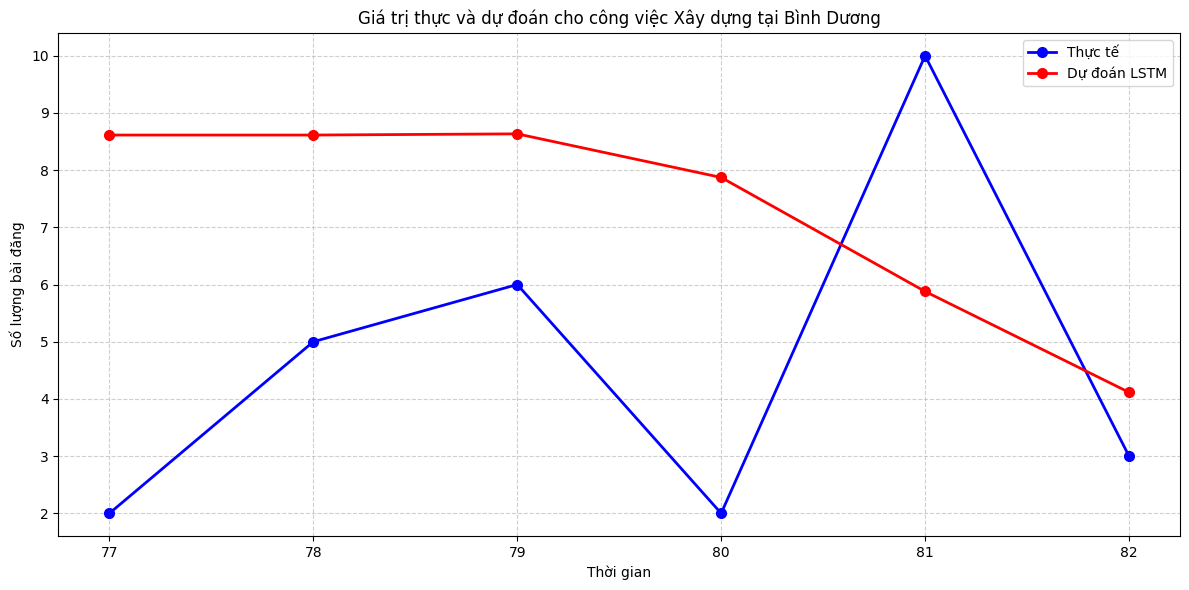

Không có dữ liệu cho công việc Xây dựng tại Bình Định
Không có dữ liệu cho công việc Xây dựng tại Hưng Yên
Không có dữ liệu cho công việc Xây dựng tại Nghệ An
Không có dữ liệu cho công việc Xây dựng tại Tây Ninh
Không có dữ liệu cho công việc Xây dựng tại Lâm Đồng
Không có dữ liệu cho công việc Xây dựng tại Tiền Giang
Không có dữ liệu cho công việc Xây dựng tại Bắc Giang
Không có dữ liệu cho công việc Xây dựng tại Bến Tre


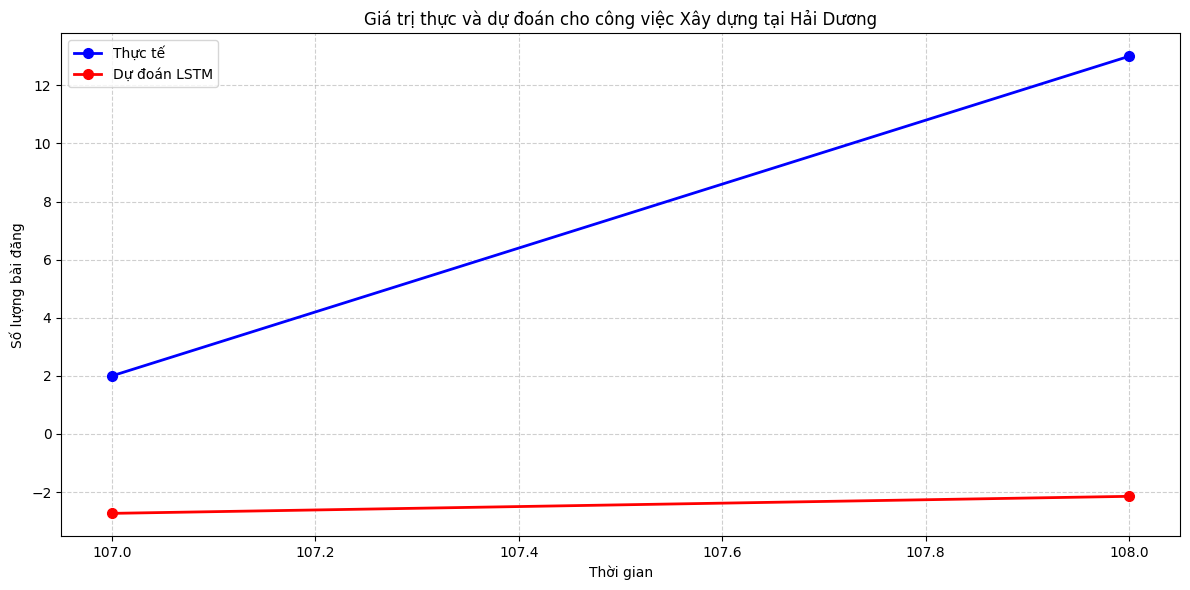

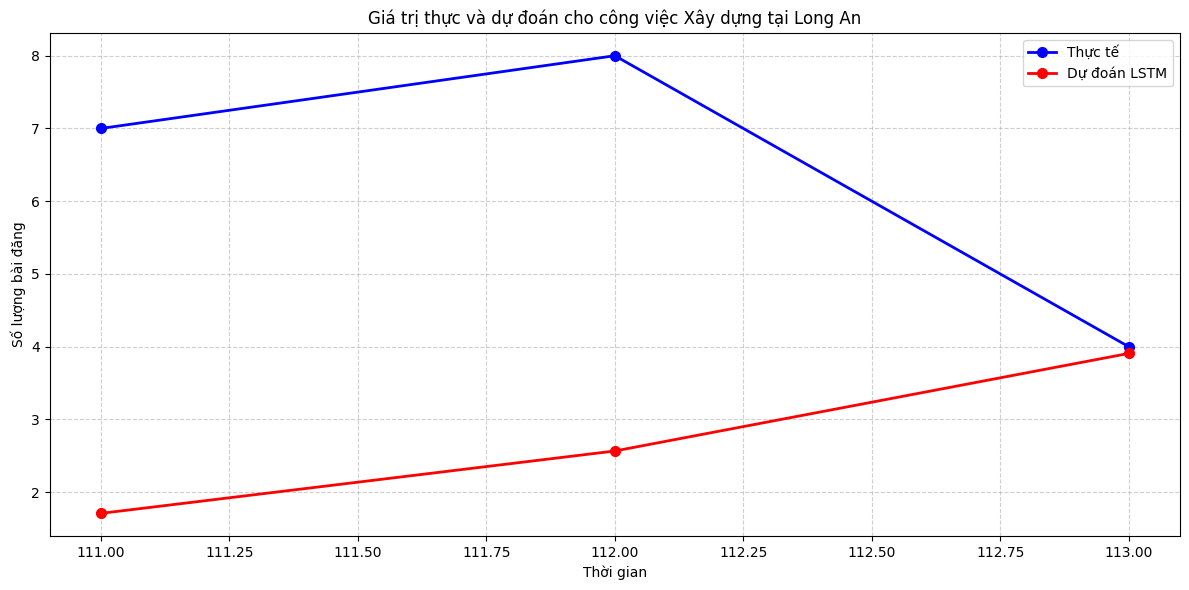

Không có dữ liệu cho công việc Xây dựng tại Quảng Ninh


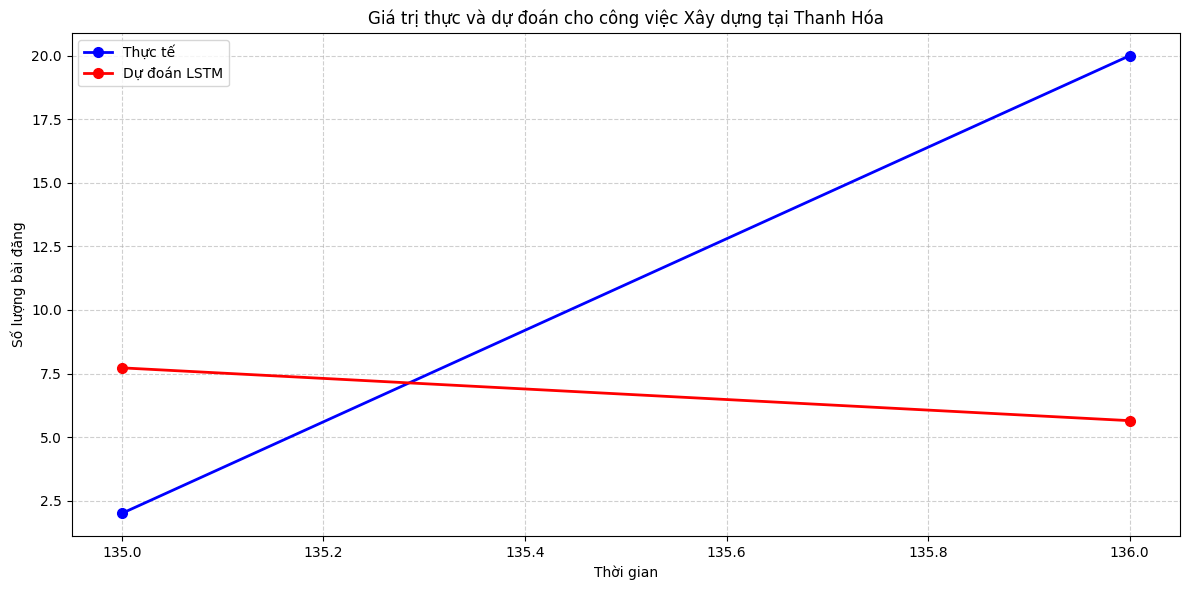

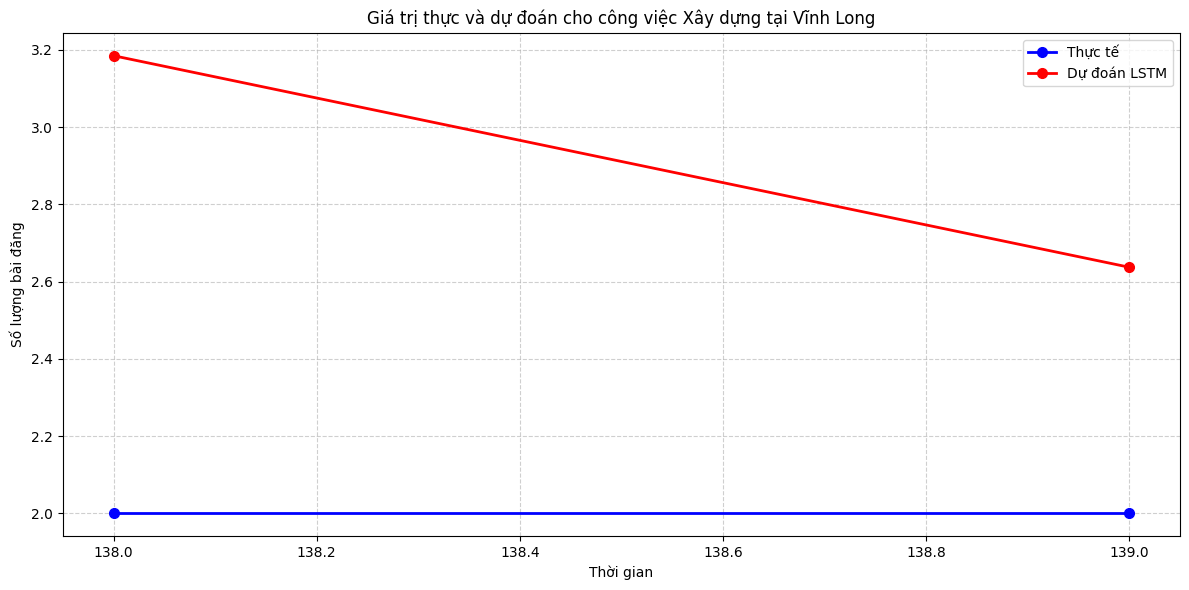

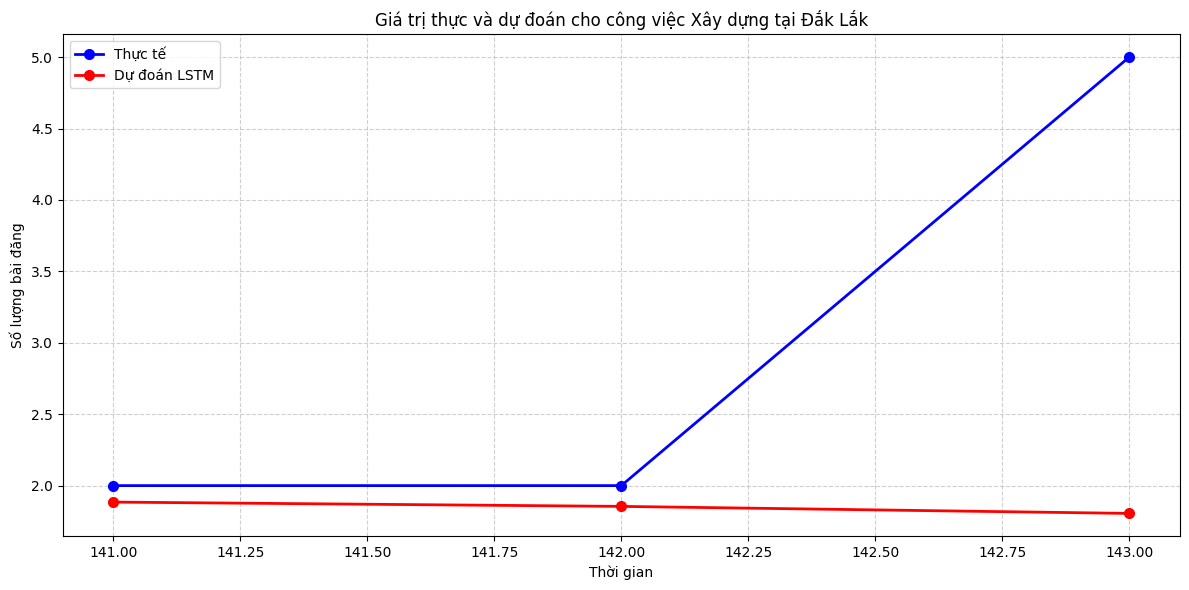

Không có dữ liệu cho công việc Y tế - Chăm sóc sức khỏe tại Bắc Ninh


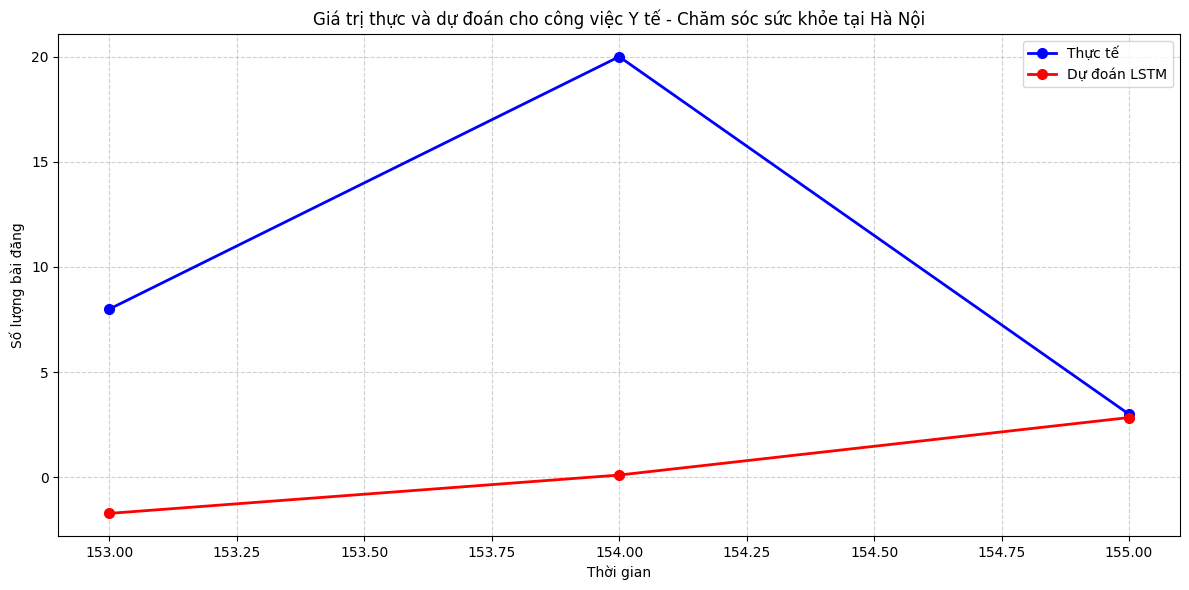

Không có dữ liệu cho công việc Y tế - Chăm sóc sức khỏe tại Hải Phòng
Không có dữ liệu cho công việc Y tế - Chăm sóc sức khỏe tại Phú Yên
Không có dữ liệu cho công việc Y tế - Chăm sóc sức khỏe tại Quảng Ngãi


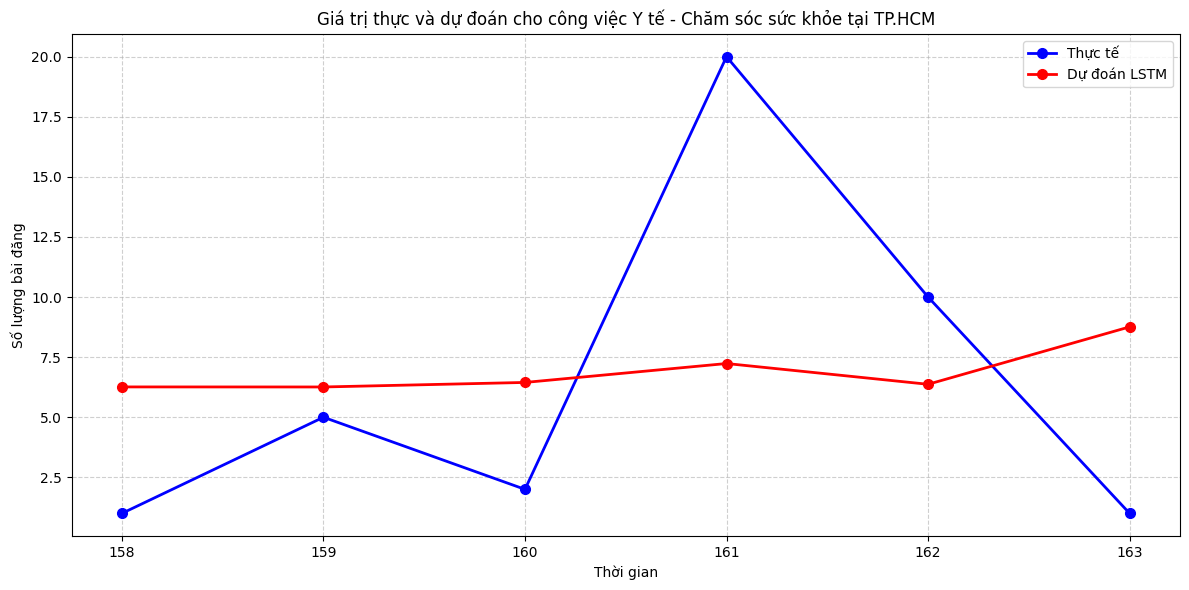

Không có dữ liệu cho công việc Y tế - Chăm sóc sức khỏe tại Đà Nẵng
Không có dữ liệu cho công việc Y tế - Chăm sóc sức khỏe tại Đồng Nai
Không có dữ liệu cho công việc Y tế - Chăm sóc sức khỏe tại Bà Rịa - Vũng Tàu
Không có dữ liệu cho công việc Y tế - Chăm sóc sức khỏe tại Bình Dương
Không có dữ liệu cho công việc Y tế - Chăm sóc sức khỏe tại Bình Định
Không có dữ liệu cho công việc Y tế - Chăm sóc sức khỏe tại Hưng Yên
Không có dữ liệu cho công việc Y tế - Chăm sóc sức khỏe tại Nghệ An
Không có dữ liệu cho công việc Y tế - Chăm sóc sức khỏe tại Tây Ninh
Không có dữ liệu cho công việc Y tế - Chăm sóc sức khỏe tại Lâm Đồng
Không có dữ liệu cho công việc Y tế - Chăm sóc sức khỏe tại Tiền Giang
Không có dữ liệu cho công việc Y tế - Chăm sóc sức khỏe tại Bắc Giang
Không có dữ liệu cho công việc Y tế - Chăm sóc sức khỏe tại Bến Tre
Không có dữ liệu cho công việc Y tế - Chăm sóc sức khỏe tại Hải Dương


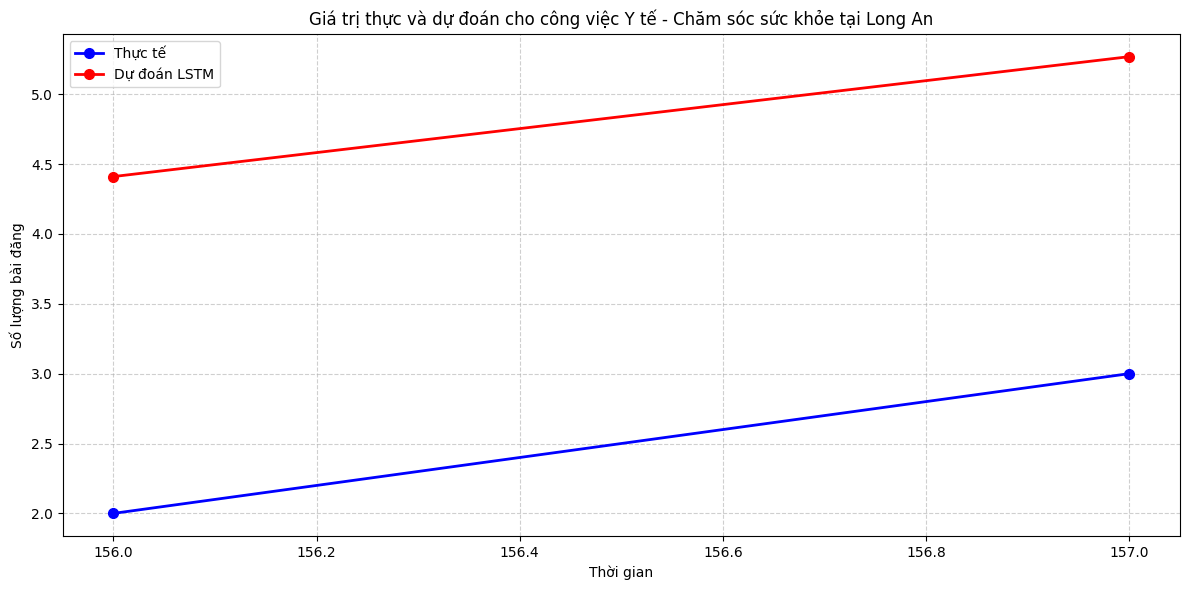

Không có dữ liệu cho công việc Y tế - Chăm sóc sức khỏe tại Quảng Ninh
Không có dữ liệu cho công việc Y tế - Chăm sóc sức khỏe tại Thanh Hóa
Không có dữ liệu cho công việc Y tế - Chăm sóc sức khỏe tại Vĩnh Long
Không có dữ liệu cho công việc Y tế - Chăm sóc sức khỏe tại Đắk Lắk
Không có dữ liệu cho công việc Điện - Điện tử - Điện lạnh tại Bắc Ninh


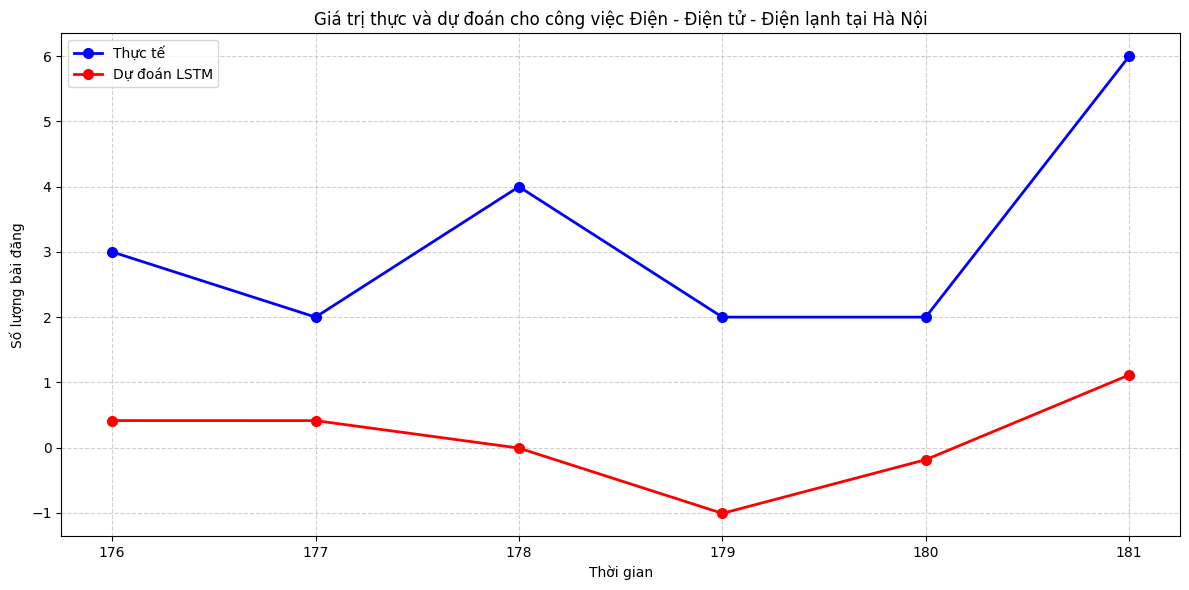

Không có dữ liệu cho công việc Điện - Điện tử - Điện lạnh tại Hải Phòng
Không có dữ liệu cho công việc Điện - Điện tử - Điện lạnh tại Phú Yên
Không có dữ liệu cho công việc Điện - Điện tử - Điện lạnh tại Quảng Ngãi


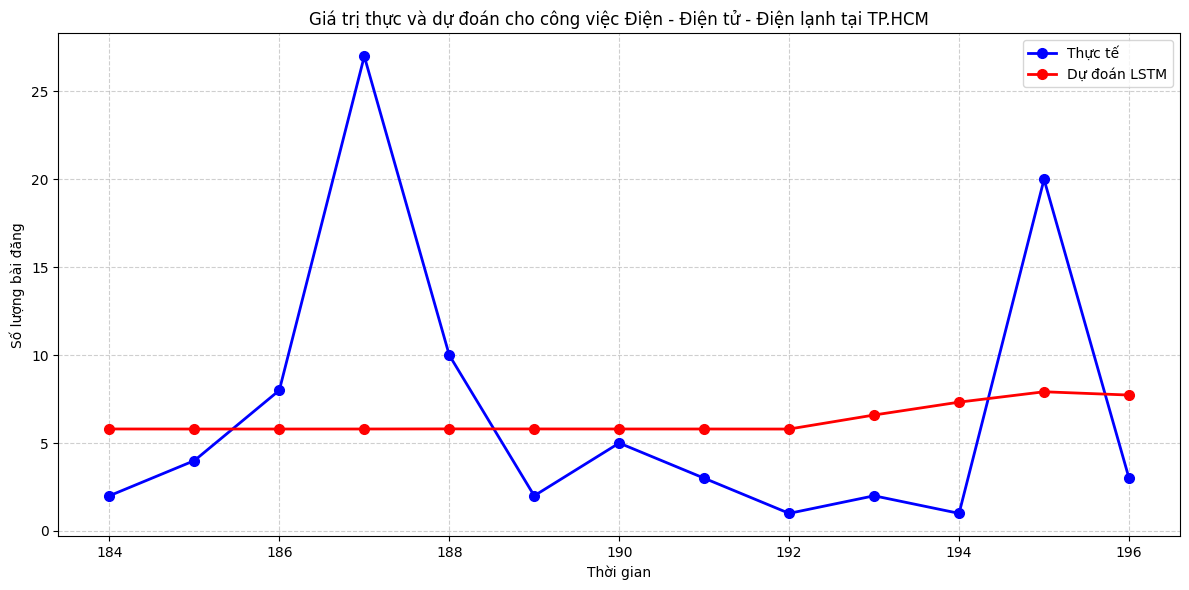

Không có dữ liệu cho công việc Điện - Điện tử - Điện lạnh tại Đà Nẵng
Không có dữ liệu cho công việc Điện - Điện tử - Điện lạnh tại Đồng Nai
Không có dữ liệu cho công việc Điện - Điện tử - Điện lạnh tại Bà Rịa - Vũng Tàu


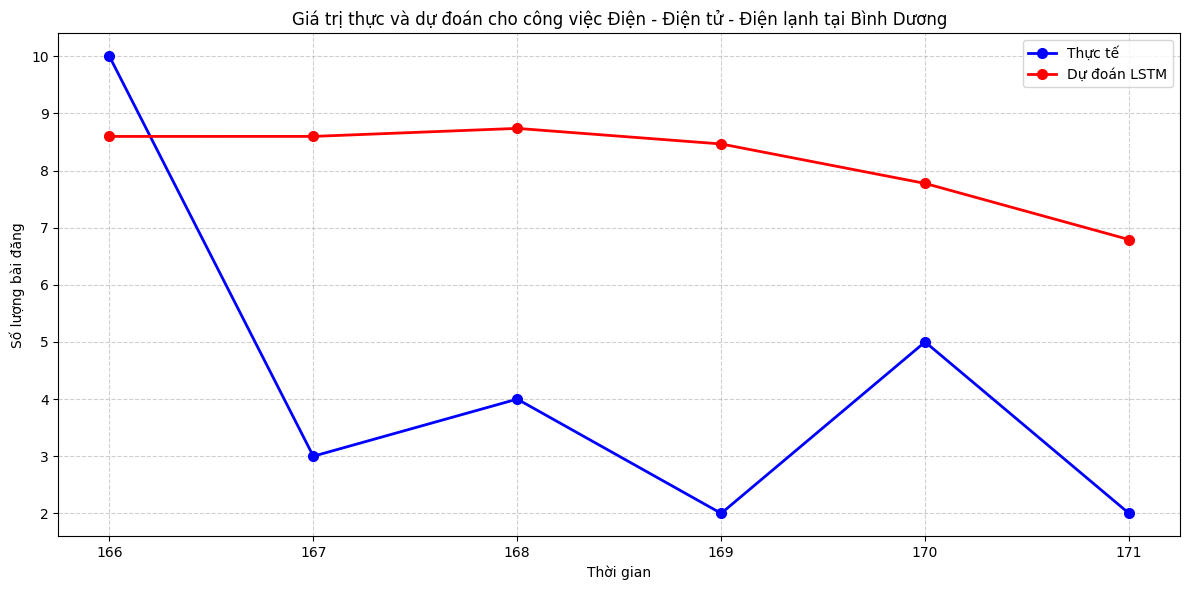

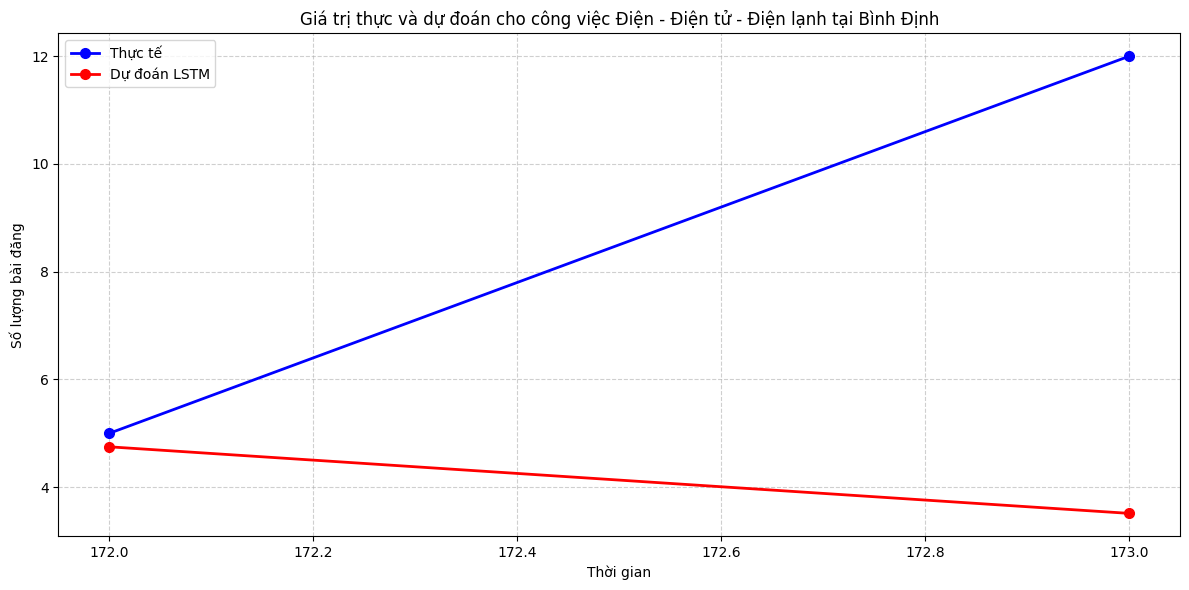

Không có dữ liệu cho công việc Điện - Điện tử - Điện lạnh tại Hưng Yên
Không có dữ liệu cho công việc Điện - Điện tử - Điện lạnh tại Nghệ An
Không có dữ liệu cho công việc Điện - Điện tử - Điện lạnh tại Tây Ninh
Không có dữ liệu cho công việc Điện - Điện tử - Điện lạnh tại Lâm Đồng
Không có dữ liệu cho công việc Điện - Điện tử - Điện lạnh tại Tiền Giang
Không có dữ liệu cho công việc Điện - Điện tử - Điện lạnh tại Bắc Giang
Không có dữ liệu cho công việc Điện - Điện tử - Điện lạnh tại Bến Tre
Không có dữ liệu cho công việc Điện - Điện tử - Điện lạnh tại Hải Dương
Không có dữ liệu cho công việc Điện - Điện tử - Điện lạnh tại Long An
Không có dữ liệu cho công việc Điện - Điện tử - Điện lạnh tại Quảng Ninh
Không có dữ liệu cho công việc Điện - Điện tử - Điện lạnh tại Thanh Hóa
Không có dữ liệu cho công việc Điện - Điện tử - Điện lạnh tại Vĩnh Long
Không có dữ liệu cho công việc Điện - Điện tử - Điện lạnh tại Đắk Lắk


In [409]:
def plot_predictions_for_jobs_and_cities(X_test, y_test_inv, test_predict, job_encoder, city_encoder):
    # Lấy mã hóa job và city từ X_test
    job_encoded = X_test[:, 0, 0]
    city_encoded = X_test[:, 0, 1]
    
    # Tạo DataFrame cho dữ liệu kiểm tra
    test_data = pd.DataFrame({
        'job_encoded': job_encoded,
        'city_encoded': city_encoded,
        'actual': y_test_inv.flatten(),
        'predicted': test_predict.flatten()
    })
    
    # Chuyển mã hóa thành tên công việc và thành phố
    test_data['job'] = job_encoder.inverse_transform(test_data['job_encoded'].astype(int))
    test_data['city'] = city_encoder.inverse_transform(test_data['city_encoded'].astype(int))

    # Lấy danh sách công việc và thành phố duy nhất
    unique_jobs = test_data['job'].unique()
    unique_cities = test_data['city'].unique()
    
    for job in unique_jobs:
        for city in unique_cities:
            job_city_data = test_data[(test_data['job'] == job) & (test_data['city'] == city)]
            if len(job_city_data) > 1:
                plt.figure(figsize=(12, 6))
                plt.plot(job_city_data.index, job_city_data['actual'], label='Thực tế', color='blue',marker='o', markersize=7, linestyle='-', linewidth=2)
                plt.plot(job_city_data.index, job_city_data['predicted'], label='Dự đoán LSTM', color='red', marker='o', markersize=7, linestyle='-', linewidth=2)
                plt.xlabel('Thời gian')
                plt.ylabel('Số lượng bài đăng')
                plt.title(f'Giá trị thực và dự đoán cho công việc {job} tại {city}')
                plt.legend()
                plt.grid(linestyle='--', alpha=0.6)
                plt.tight_layout()
                plt.show()
            else:
                print(f"Không có dữ liệu cho công việc {job} tại {city}")
                
plot_predictions_for_jobs_and_cities(X_test, y_test_inv, test_predict, job_encoder, city_encoder)